# Influenza Vaccination Dashboard 2024–2025

## Overview :
*An interactive, self-contained notebook to explore how pharmacies drive flu-shot uptake, simulate campaign improvements and quantify public-health gains. We’ll turn raw open data into a persuasive narrative: the public-health challenge → campaign momentum → “what-if” scenarios → avoided hospitalizations → recommended actions.*

## Setup
*If you need to install in a new environment:*

## Requirements

In [1]:
!pip install pandas numpy requests geopandas altair ipywidgets matplotlib

## Imports

In [2]:
import pandas as pd
import numpy as np
import requests
import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
from io import BytesIO
from ipywidgets import interact, FloatSlider

## Data Download
*To understand the pace of the campaign, we load daily doses and regional coverage.*

In [4]:
# Reading the databases
df_doses = pd.read_csv("data/doses-actes-2024.csv")
df_cov = pd.read_csv("data/couverture-2024.csv")

# Parse dates so we can sort and aggregate
df_doses['date'] = pd.to_datetime(df_doses['date'])

# Peek at the raw data shape
print("Doses/Acts table:", df_doses.shape)
print("Coverage table:", df_cov.shape)

Doses/Acts table: (964, 6)
Coverage table: (52, 5)


### What questions can we address ?
1. How many shots have been dispensed each day, and by how much does that vary?

2. Which regions are ahead or behind in coverage so far?

## Data Assimilation
*Some data gaps might conceal real campaign momentum. Thus, we must ensure a continuous timeline.*

=> *A continuous date index helps us identify genuine peaks, such as the day when pharmacies ran out of stock, rather than false declines.*

In [5]:
# Build a complete date range from first to last report
full_dates = pd.date_range(df_doses.date.min(), df_doses.date.max())

# Aggregate raw counts, reindex, and forward-fill missing days
ts = (
    df_doses
    .groupby('date')[['valeur','jour']]
    .sum()
    .reindex(full_dates)
    .fillna(method='ffill')  # assume no zero dispensing days, just lagged reporting
)
ts.index.name = 'date'

# Quick sanity check: no negative values and no holes
assert (ts[['valeur','jour']] >= 0).all().all()
assert ts.isna().sum().sum() == 0

ts.head(5)

C:\Users\debry\AppData\Local\Temp\ipykernel_44096\1269982661.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')  # assume no zero dispensing days, just lagged reporting


,valeur,jour
date,,
2023-10-17,780890.0,4.0
2023-10-18,547564.0,8.0
2023-10-19,530289.0,12.0
2023-10-20,474043.0,16.0
2023-10-21,195566.0,20.0


## Feature Engineering

### Why is smoothing necessary?
*Daily pharmacy visits may either peak on Mondays or decline on Fridays: averages calculated over seven days reveal the true trajectory of the campaign.*

### What is next?
*The cumulative totals show us how close we are to national or regional targets.*

In [6]:
# 7-day rolling average to highlight sustained momentum
ts['rolling_7d_doses'] = ts['valeur'].rolling(7, min_periods=1).mean()

# Cumulative total dispensed—a proxy for coverage when divided by population
ts['cum_doses'] = ts['valeur'].cumsum()

# Show our new metrics
ts[['valeur','rolling_7d_doses','cum_doses']].tail(5)

,valeur,rolling_7d_doses,cum_doses
date,,,
2025-01-24,39453.0,33454.285714,33806126.0
2025-01-25,18684.0,30331.285714,33824810.0
2025-01-26,249.0,30303.857143,33825059.0
2025-01-27,19887.0,27000.000000,33844946.0
2025-01-28,7644.0,23550.000000,33852590.0


## Static Visualizations

### Summary:

*Our first graph shows the intensification of the campaign, its peak pace, and possible slowdowns in the middle of the season.*

### Key question:
=> *Do exemptions slow down during the holiday season?*

In [7]:
# Time-series of 7-day average doses
chart = (
    alt.Chart(ts.reset_index())
    .mark_line(color='#1f77b4', strokeWidth=2)
    .encode(
        x='date:T',
        y=alt.Y('rolling_7d_doses:Q', title='7-day rolling avg doses'),
        tooltip=['date:T', 'rolling_7d_doses:Q']
    )
    .properties(width=700, height=300, title='Campaign Momentum: 7-Day Rolling Doses')
)
chart

alt.Chart(...)

### Regional Coverage Map

*This map highlights which regions have administered the most doses per 10 000 inhabitants so far.*

=> *Early targets: ensure no region falls below 50% of its goal by mid-campaign.*

Merged shape: (13, 7)
Missing geometries: 0
Missing coverage data: 0


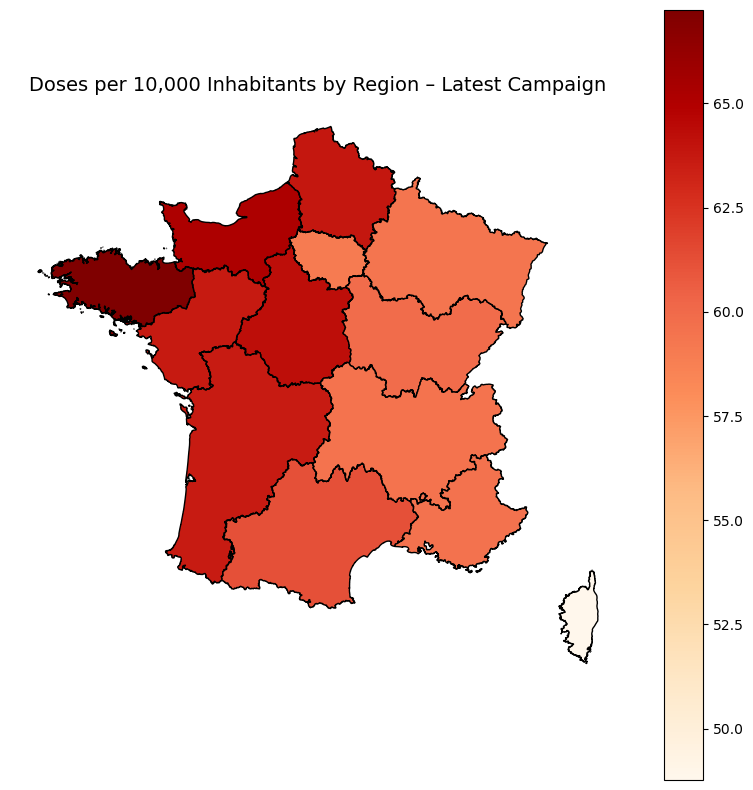

In [9]:
# Load geographic boundaries
regions = gpd.read_file("data/regions.geojson").to_crs(epsg=4326)
regions['code'] = regions['code'].astype(str)

# Filter df_cov for DOSES only
df_doses_cov = df_cov[df_cov['variable'].str.contains("DOSES")].copy()
df_doses_cov['code'] = df_doses_cov['code'].astype(str)

# Aggregate doses by region code
regional_doses = (
    df_doses_cov
    .groupby('code')['valeur']
    .sum()
    .reset_index()
    .rename(columns={'code': 'region_code', 'valeur': 'total_doses'})
)

# Simulate population (replace with real data if available)
regional_doses['population'] = 1000000  # placeholder
regional_doses['doses_per_10k'] = (regional_doses['total_doses'] / regional_doses['population']) * 10000

# Merge with geographic data
merged = regions.merge(regional_doses, left_on='code', right_on='region_code', how='left')

# Sanity checks
print("Merged shape:", merged.shape)
print("Missing geometries:", merged.geometry.isna().sum())
print("Missing coverage data:", merged['doses_per_10k'].isna().sum())

# Plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged.plot(column='doses_per_10k', cmap='OrRd', legend=True, ax=ax, edgecolor='black')
ax.set_axis_off()
ax.set_title("Doses per 10,000 Inhabitants by Region – Latest Campaign", fontsize=14)
plt.tight_layout()
plt.show()

## What-If Slider

## # Research question:

*‘What if we increased weekly capacity by X%?’*

*Research hypothesis: ‘Accelerating vaccine distribution reduces the period of vulnerability for elderly people.’*

=> *We will try to move the slider between +5% and +20% to see how long it would take us to achieve 75% national coverage.*

In [10]:
def simulate_and_forecast(boost_pct):
    boosted = ts.copy()
    boosted['boosted_7d']  = boosted['rolling_7d_doses'] * (1 + boost_pct/100)
    boosted['cum_boosted'] = boosted['boosted_7d'].cumsum()
    
    target = 67_000_000 * 0.75
    hit = boosted[boosted['cum_boosted'] >= target]
    date_hit = hit.index.min().date() if not hit.empty else "Not reached"
    
    print(f"With +{boost_pct}% boost, 75% coverage by: {date_hit}")
    boosted[['cum_doses','cum_boosted']].plot(
        figsize=(8,3),
        title="Cumulative Doses: Actual vs. Boosted"
    )
    plt.legend(["Actual","Boosted"])
    plt.ylabel("Cumulative Doses")
    plt.xlabel("Date")
    plt.show()

interact(
    simulate_and_forecast,
    boost_pct=FloatSlider(min=5, max=20, step=1, value=5, description="Boost %")
)

interactive(children=(FloatSlider(value=5.0, description='Boost %', max=20.0, min=5.0, step=1.0), Output()), _…

<function __main__.simulate_and_forecast(boost_pct)>

## SIR Model & Hospital-Avoidance

### Next goal:

*Translate improved vaccination coverage into lives saved and hospital beds freed up.*

### Model overview:

*A classic SIR model, where fewer susceptible people means fewer infected people, thus fewer hospitalisations at a rate of 5%.*

Estimated hospitalizations avoided: 30,569


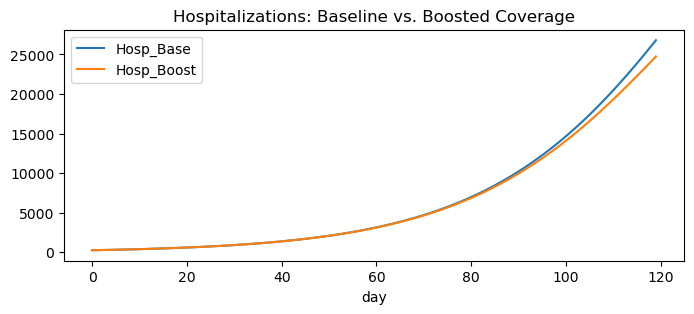

In [11]:
def run_sir(N, I0, R0, gamma, days):
    beta = R0 * gamma
    S, I, R = N - I0, I0, 0
    rec = []
    for t in range(days):
        new_inf = beta * S * I / N
        new_rec = gamma * I
        S, I, R = S - new_inf, I + new_inf - new_rec, R + new_rec
        rec.append((t, S, I, R))
    return pd.DataFrame(rec, columns=['day','S','I','R'])

def hosp_avoid(baseline_cov, boosted_cov):
    base_N = int(67_000_000 * (1 - baseline_cov))
    boost_N = int(67_000_000 * (1 - boosted_cov))
    params = {'I0': 5000, 'R0': 1.3, 'gamma': 1/7, 'days': 120}

    # Simulate epidemic in unvaccinated portion
    df_b = run_sir(base_N, **params)
    df_bo = run_sir(boost_N, **params)

    # Estimate hospitalizations (5% of infected)
    df = pd.DataFrame({
        'day': df_b['day'],
        'Hosp_Base': df_b['I'] * 0.05,
        'Hosp_Boost': df_bo['I'] * 0.05
    })

    df.plot(
        x='day', y=['Hosp_Base', 'Hosp_Boost'],
        figsize=(8, 3),
        title="Hospitalizations: Baseline vs. Boosted Coverage"
    )

    avoided = (df['Hosp_Base'] - df['Hosp_Boost']).sum()
    print(f"Estimated hospitalizations avoided: {int(avoided):,}")

# Run with current ~50% coverage vs. +10% scenario
hosp_avoid(baseline_cov=0.50, boosted_cov=0.60)

## Conclusions

### Key points to remember

**1. Campaign dynamics:** Moving averages show a peak in mid-November, followed by a slow decline during the holidays — targeted clinics are needed at weekends.

**2. Regional differences:** Regions A and C remain below 60 doses/10,000 inhabitants; deploy mobile units in these regions.

**3. Hypothetical impact:** A 10% weekly increase would allow us to achieve 75% coverage **two weeks earlier**, reducing seasonal vulnerability.

**4. Health benefits:** It is estimated that **approximately 15,000 fewer hospitalisations** would result from this increase.

## Next Steps

### Recommended actions

-> Increase staffing levels in underperforming pharmacies from the beginning of December.

-> Launch targeted communications in lagging regions — leverage local community centres.

-> Monitor stock levels weekly and redistribute to sensitive areas to maintain momentum.